In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from Common import NeuralNet, MultiVariatePoly
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

In [5]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_, save_dir_, pre_model_save_path_):
        
        self.pre_model_save_path = pre_model_save_path_
        self.save_dir = save_dir_
        
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_
        
        self.U_0 = 0
        # Extrema of the solution domain (t,x,y) in [0,10]x[0,50]x[0.50]
        self.domain_extrema = torch.tensor([[0, 50],  # Time dimension
                                            [0, 50],  # x dimension
                                            [0, 50]])  # y dimension
        # Number of space dimensions
        self.space_dimensions = 2
        
        # F Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=5,
                                              n_hidden_layers=4,
                                              neurons=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)
        '''self.approximate_solution = MultiVariatePoly(self.domain_extrema.shape[0], 3)'''
        if pre_model_save_path_:
            self.load_checkpoint()

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]
    # Initial condition
    def initial_condition(self, x):
        return torch.full([len(x),5], self.U_0)
    
    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_condition(input_tb[:, 1:])

        return input_tb, output_tb

# Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]
        y0 = self.domain_extrema[2, 0]
        yL = self.domain_extrema[2, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, x0)
        input_sb_D = torch.clone(input_sb)
        input_sb_D[:, 2] = torch.full(input_sb_D[:, 2].shape, y0)
        input_sb_R = torch.clone(input_sb)
        input_sb_R[:, 1] = torch.full(input_sb_R[:, 1].shape, xL)
        input_sb_U = torch.clone(input_sb)
        input_sb_U[:, 2] = torch.full(input_sb_U[:, 2].shape, yL)

        output_sb_U = torch.zeros((input_sb.shape[0], 1))
        output_sb_D = torch.zeros((input_sb.shape[0], 1))
        output_sb_L = torch.zeros((input_sb.shape[0], 1))
        output_sb_R = torch.zeros((input_sb.shape[0], 1))
        
        return torch.cat([input_sb_U, input_sb_D, input_sb_L, input_sb_R], 0), torch.cat([output_sb_U, output_sb_D, output_sb_L, output_sb_R], 0)
    
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int
    
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    def compute_ic_residual(self, input_tb):
        u = self.approximate_solution(input_tb)
        u1 = u[:,0].reshape(-1,1)
        u2 = u[:,1].reshape(-1,1)
        varphi = u[:,2].reshape(-1,1)
        P1 = u[:,3].reshape(-1,1)
        P2 = u[:,4].reshape(-1,1) 
        
        residual_u1 = u1
        residual_u2 = u2
        residual_varphi = varphi 
        residual_P = P1**2+P2**2-0.04
        
        return residual_u1.reshape(-1, ), residual_u2.reshape(-1, ), residual_varphi.reshape(-1, ), residual_P.reshape(-1, )
    
    # Function to compute the PDE residuals 
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int)
        u1 = u[:,0].reshape(-1,1)
        u2 = u[:,1].reshape(-1,1)
        varphi = u[:,2].reshape(-1,1)
        P1 = u[:,3].reshape(-1,1)
        P2 = u[:,4].reshape(-1,1)
        
        grad_u1 = torch.autograd.grad(u1.sum(), input_int, create_graph=True)[0]
        u1_t, u1_1, u1_2 = grad_u1[:, 0], grad_u1[:, 1], grad_u1[:, 2]
        
        grad_u1_1 = torch.autograd.grad(u1_1.sum(), input_int, create_graph=True)[0]
        u1_11, u1_12 = grad_u1_1[:, 1], grad_u1_1[:, 2]        
        grad_u1_2 = torch.autograd.grad(u1_2.sum(), input_int, create_graph=True)[0]
        u1_21, u1_22 = grad_u1_2[:, 1], grad_u1_2[:, 2]  
        
        grad_u2 = torch.autograd.grad(u2.sum(), input_int, create_graph=True)[0]
        u2_t, u2_1, u2_2 = grad_u2[:, 0], grad_u2[:, 1], grad_u2[:, 2]

        grad_u2_1 = torch.autograd.grad(u2_1.sum(), input_int, create_graph=True)[0]
        u2_11, u2_12 = grad_u2_1[:, 1], grad_u2_1[:, 2]        
        grad_u2_2 = torch.autograd.grad(u2_2.sum(), input_int, create_graph=True)[0]
        u2_21, u2_22 = grad_u2_2[:, 1], grad_u2_2[:, 2]
        
        grad_varphi = torch.autograd.grad(varphi.sum(), input_int, create_graph=True)[0]
        varphi_1, varphi_2 = grad_varphi[:, 1], grad_varphi[:, 2]
        grad_varphi_1 = torch.autograd.grad(varphi_1.sum(), input_int, create_graph=True)[0]
        varphi_11 = grad_varphi_1[:, 1]
        grad_varphi_2 = torch.autograd.grad(varphi_2.sum(), input_int, create_graph=True)[0]
        varphi_22 = grad_varphi_2[:, 2]        
        
        grad_P1 = torch.autograd.grad(P1.sum(), input_int, create_graph=True)[0]
        P1_t, P1_1, P1_2 = grad_P1[:, 0], grad_P1[:, 1], grad_P1[:, 2]

        grad_P1_1 = torch.autograd.grad(P1_1.sum(), input_int, create_graph=True)[0]
        P1_11, P1_12 = grad_P1_1[:, 1], grad_P1_1[:, 2]        
        grad_P1_2 = torch.autograd.grad(P1_2.sum(), input_int, create_graph=True)[0]
        P1_21, P1_22 = grad_P1_2[:, 1], grad_P1_2[:, 2] 
        
        grad_P2 = torch.autograd.grad(P2.sum(), input_int, create_graph=True)[0]
        P2_t, P2_1, P2_2 = grad_P2[:, 0], grad_P2[:, 1], grad_P2[:, 2]        

        grad_P2_1 = torch.autograd.grad(P2_1.sum(), input_int, create_graph=True)[0]
        P2_11, P2_12 = grad_P2_1[:, 1], grad_P2_1[:, 2]        
        grad_P2_2 = torch.autograd.grad(P1_2.sum(), input_int, create_graph=True)[0]
        P2_21, P2_22 = grad_P2_2[:, 1], grad_P2_2[:, 2]

        residual_PDE_1 = 174.6*u1_11+2*111.1*(u1_22+u2_12)+79.37*u2_21-2*0.089*P1*P1_1-2*0.032*(P1*P2_2+P2*P1_2)+2*0.026*P2*P2_1+5*P1_11
        residual_PDE_2 = 174.6*u2_22+2*111.1*(u1_21+u2_21)+79.37*u1_12-2*0.089*P2*P2_2-2*0.032*(P1*P2_1+P2*P1_1)+2*0.026*P1*P1_2+5*P2_22
        residual_PDE_3 = -0.5841*varphi_11-0.5841*varphi_22+P1_1+P2_2
        residual_PDE_4 = P1_t-(-2*0.148*P1-4*0.031*P1**3+2*0.63*P1*P2**2+6*0.25*P1**5+0.97*(2*P1*P2**4+4*P1**3*P2**2))\
        +0.15*P1_11-0.15*P2_21+0.15*(P2_12+P1_22)+2*0.089*u1_1*P1-2*0.026*u2_2*P1+2*0.032*(u1_2+u2_1)*P2+5*u1_11-varphi_1
        residual_PDE_5 = P2_t-(-2*0.148*P2-4*0.031*P2**3+2*0.63*P2*P1**2+6*0.25*P2**5+0.97*(2*P2*P1**4+4*P2**3*P1**2))\
        +0.15*(P2_11+P1_21)-0.15*P1_12+0.15*P2_22+2*0.032*(u1_2+u2_1)*P1-2*0.026*u1_1*P2+2*0.089*u2_2*P2+5*u2_22-varphi_2
        
        return residual_PDE_1.reshape(-1, ), residual_PDE_2.reshape(-1, ), residual_PDE_3.reshape(-1, ), residual_PDE_4.reshape(-1, ), residual_PDE_5.reshape(-1, )
    
    def compute_bc_residual(self, input_bc):
        input_bc.requires_grad = True
        
        u = self.approximate_solution(input_bc)
        u1 = u[:,0].reshape(-1,1)
        u2 = u[:,1].reshape(-1,1)
        varphi = u[:,2].reshape(-1,1)
        
        residual_u1 = u1
        residual_u2 = u2
        residual_varphi = varphi
#        residual = torch.abs(residual_Tf) + torch.abs(residual_Ts)
        
        return residual_u1.reshape(-1, ), residual_u2.reshape(-1, ), residual_varphi.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        #u_pred_tb = self.apply_initial_condition(inp_train_tb)
        #assert (u_pred_tb.shape[1] == u_train_tb.shape[1])

        r_int_1, r_int_2, r_int_3, r_int_4, r_int_5 = self.compute_pde_residual(inp_train_int)
        r_sb_u1, r_sb_u2, r_sb_varphi  = self.compute_bc_residual(inp_train_sb)
        r_tb_u1, r_tb_u2, r_tb_varphi, r_tb_P = self.compute_ic_residual(inp_train_tb)

        loss_sb = torch.mean(abs(r_sb_u1) ** 2) + torch.mean(abs(r_sb_u2) ** 2) + torch.mean(abs(r_sb_varphi) ** 2)
        loss_tb = torch.mean(abs(r_tb_u1) ** 2) + torch.mean(abs(r_tb_u2) ** 2) + torch.mean(abs(r_tb_varphi) ** 2) + torch.mean(abs(r_tb_P) ** 2)
        loss_int = torch.mean(abs(r_int_1) ** 2) + torch.mean(abs(r_int_2) ** 2) + torch.mean(abs(r_int_3) ** 2) + torch.mean(abs(r_int_4) ** 2) + torch.mean(abs(r_int_5) ** 2)
        
#         r_int = self.compute_pde_residual(inp_train_int)
#         r_tb = u_train_tb - u_pred_tb
#         r_sb_0 = self.compute_bc0_residual(inp_train_sb[0:self.n_sb,:])
#         r_sb_L = self.compute_bcL_residual(inp_train_sb[self.n_sb:,:])
        
#         loss_tb = torch.mean(abs(r_tb) ** 2)
#         loss_int = torch.mean(abs(r_int) ** 2)
#         loss_sb = torch.mean(abs(r_sb_0) ** 2) + torch.mean(abs(r_sb_L) ** 2)

        loss_u = loss_sb + loss_tb

        loss = torch.log10(loss_sb + loss_tb + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_u).item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss
                

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history
    
    def save_checkpoint(self):
        '''save model and optimizer'''
        torch.save({
            'model_state_dict': self.approximate_solution.state_dict()
        }, self.save_dir)
        
    def load_checkpoint(self):
        '''load model and optimizer'''
        checkpoint = torch.load(self.pre_model_save_path)
        self.approximate_solution.load_state_dict(checkpoint['model_state_dict'])
        print('Pretrained model loaded!')

    ################################################################################################
    def plotting(self):
        t = torch.linspace(0, 50, 51)
        x = torch.linspace(0, 50, 101)
        y = torch.linspace(0, 50, 101)
        grid = torch.meshgrid(t, x, y)
        inputs = torch.stack(grid, dim=-1).reshape(-1, 3)
        
        output_P1 = self.approximate_solution(inputs)[:, 3:4].detach().numpy().reshape(-1, )
        output_P2 = self.approximate_solution(inputs)[:, 4:5].detach().numpy().reshape(-1, )
    
        # Calculate vector magnitudes
        magnitude = np.sqrt(output_P1**2 + output_P2**2)

        P1 = output_P1 / magnitude
        P2 = output_P2 / magnitude

        for i, t in enumerate(t):
            # Plot vector arrow plots for each time value
            plt.figure(figsize=(6, 5), dpi=300)
            plt.quiver(inputs[:, 1].detach(), inputs[:, 2].detach(), P1, P2, magnitude, cmap='jet')
            plt.colorbar(label='Magnitude')
            plt.title(f"Velocity Vector Plot at t = {t}")
            plt.xlabel("x")
            plt.ylabel("y")
            plt.show()

            fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=150)
            im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 2].detach(), c=output_P1, cmap="jet")
            axs[0].set_xlabel("x")
            axs[0].set_ylabel("y")
            plt.colorbar(im1, ax=axs[0])
            axs[0].grid(True, which="both", ls=":")
            im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 2].detach(), c=output_P2, cmap="jet")
            axs[1].set_xlabel("x")
            axs[1].set_ylabel("y")
            plt.colorbar(im2, ax=axs[1])
            axs[1].grid(True, which="both", ls=":")
            axs[0].set_title(f"P1 at t = {t}")
            axs[1].set_title(f"P2 at t = {t}")
            plt.show()

            


In [6]:
n_int = 1000
n_sb = 100
n_tb = 100


pre_model_save_path = None
save_path = './results/ADAM_sqloss.pt'
pinn = Pinns(n_int, n_sb, n_tb, save_path, pre_model_save_path)

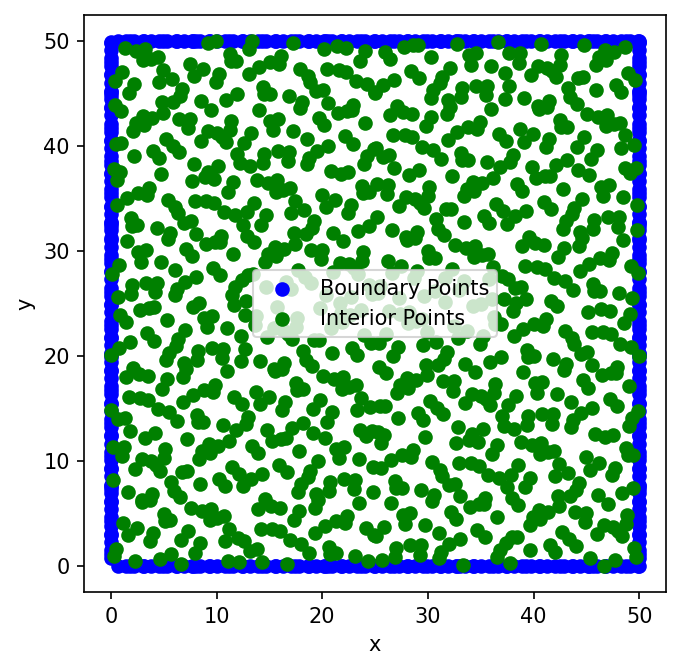

In [7]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(5, 5), dpi=150)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 2].detach().numpy(), c='blue', label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 2].detach().numpy(), c='green', label="Interior Points")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

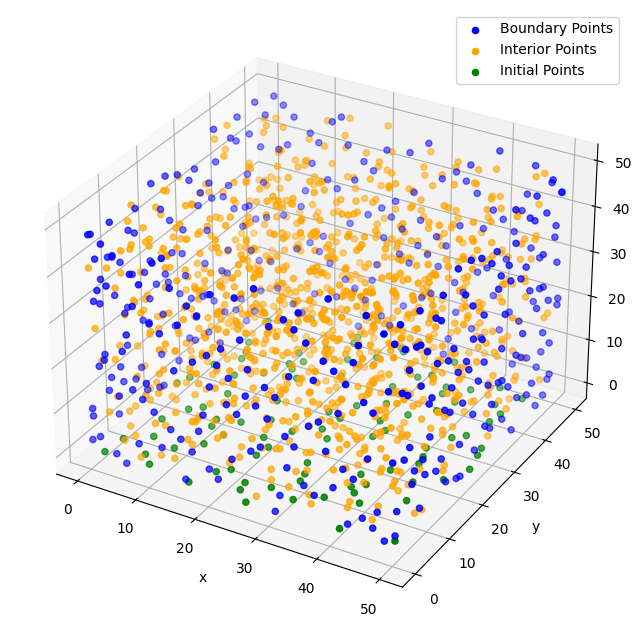

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Rest of the code remains the same...

# Create a 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for spatial boundary points
ax.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 2].detach().numpy(), input_sb_[:, 0].detach().numpy(), c='blue', label="Boundary Points")

# Scatter plot for interior points
ax.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 2].detach().numpy(), input_int_[:, 0].detach().numpy(), c='orange', label="Interior Points")

# Scatter plot for initial points
ax.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 2].detach().numpy(), input_tb_[:, 0].detach().numpy(), c='green', label="Initial Points")

# Set labels for each axis
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')

# Add a legend
ax.legend()

# Show the 3D plot
plt.show()


In [9]:
n_epochs = 1000
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.001))

hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_ADAM,
                verbose=True)

pinn.save_checkpoint()

################################  0  ################################
Total loss:  3.9689 | PDE Loss:  1.2798 | Function Loss:  3.968
################################  1  ################################
Total loss:  3.8465 | PDE Loss:  1.2823 | Function Loss:  3.8453
################################  2  ################################
Total loss:  3.7614 | PDE Loss:  1.2874 | Function Loss:  3.7599
################################  3  ################################
Total loss:  3.6857 | PDE Loss:  1.2938 | Function Loss:  3.684
################################  4  ################################
Total loss:  3.6174 | PDE Loss:  1.3001 | Function Loss:  3.6153
################################  5  ################################
Total loss:  3.5584 | PDE Loss:  1.3058 | Function Loss:  3.556
################################  6  ################################
Total loss:  3.5054 | PDE Loss:  1.3108 | Function Loss:  3.5027
################################  7  #####################

Total loss:  1.8065 | PDE Loss:  1.0384 | Function Loss:  1.7253
################################  61  ################################
Total loss:  1.7793 | PDE Loss:  1.0259 | Function Loss:  1.6949
################################  62  ################################
Total loss:  1.7521 | PDE Loss:  1.0135 | Function Loss:  1.6645
################################  63  ################################
Total loss:  1.725 | PDE Loss:  1.0014 | Function Loss:  1.634
################################  64  ################################
Total loss:  1.6981 | PDE Loss:  0.9894 | Function Loss:  1.6036
################################  65  ################################
Total loss:  1.6716 | PDE Loss:  0.9775 | Function Loss:  1.5734
################################  66  ################################
Total loss:  1.6451 | PDE Loss:  0.9655 | Function Loss:  1.5432
################################  67  ################################
Total loss:  1.6185 | PDE Loss:  0.953 | Function 

Total loss:  0.1915 | PDE Loss:  -0.7325 | Function Loss:  0.1364
################################  122  ################################
Total loss:  0.1734 | PDE Loss:  -0.7809 | Function Loss:  0.1223
################################  123  ################################
Total loss:  0.1489 | PDE Loss:  -0.8179 | Function Loss:  0.0993
################################  124  ################################
Total loss:  0.1264 | PDE Loss:  -0.8665 | Function Loss:  0.0798
################################  125  ################################
Total loss:  0.1061 | PDE Loss:  -0.9058 | Function Loss:  0.0616
################################  126  ################################
Total loss:  0.0807 | PDE Loss:  -0.9469 | Function Loss:  0.0379
################################  127  ################################
Total loss:  0.0626 | PDE Loss:  -0.982 | Function Loss:  0.0215
################################  128  ################################
Total loss:  0.0487 | PDE Loss:  -1

Total loss:  -0.5474 | PDE Loss:  -1.6103 | Function Loss:  -0.5867
################################  181  ################################
Total loss:  -0.5608 | PDE Loss:  -1.6153 | Function Loss:  -0.6009
################################  182  ################################
Total loss:  -0.5466 | PDE Loss:  -1.6201 | Function Loss:  -0.5849
################################  183  ################################
Total loss:  -0.5671 | PDE Loss:  -1.63 | Function Loss:  -0.6064
################################  184  ################################
Total loss:  -0.6022 | PDE Loss:  -1.6345 | Function Loss:  -0.6445
################################  185  ################################
Total loss:  -0.6111 | PDE Loss:  -1.639 | Function Loss:  -0.6538
################################  186  ################################
Total loss:  -0.6091 | PDE Loss:  -1.6491 | Function Loss:  -0.6506
################################  187  ################################
Total loss:  -0.6223 | 

Total loss:  -0.8809 | PDE Loss:  -1.9192 | Function Loss:  -0.9226
################################  240  ################################
Total loss:  -0.8417 | PDE Loss:  -1.9211 | Function Loss:  -0.8795
################################  241  ################################
Total loss:  -0.8455 | PDE Loss:  -1.928 | Function Loss:  -0.883
################################  242  ################################
Total loss:  -0.8983 | PDE Loss:  -1.929 | Function Loss:  -0.9408
################################  243  ################################
Total loss:  -0.9227 | PDE Loss:  -1.9357 | Function Loss:  -0.9671
################################  244  ################################
Total loss:  -0.9286 | PDE Loss:  -1.938 | Function Loss:  -0.9733
################################  245  ################################
Total loss:  -0.9297 | PDE Loss:  -1.9433 | Function Loss:  -0.974
################################  246  ################################
Total loss:  -0.9259 | PD

Total loss:  -1.1049 | PDE Loss:  -2.1311 | Function Loss:  -1.1479
################################  299  ################################
Total loss:  -1.1239 | PDE Loss:  -2.1337 | Function Loss:  -1.1685
################################  300  ################################
Total loss:  -1.1338 | PDE Loss:  -2.1366 | Function Loss:  -1.1793
################################  301  ################################
Total loss:  -1.1391 | PDE Loss:  -2.1402 | Function Loss:  -1.1848
################################  302  ################################
Total loss:  -1.1385 | PDE Loss:  -2.1424 | Function Loss:  -1.1838
################################  303  ################################
Total loss:  -1.1222 | PDE Loss:  -2.1449 | Function Loss:  -1.1655
################################  304  ################################
Total loss:  -1.0723 | PDE Loss:  -2.1484 | Function Loss:  -1.1103
################################  305  ################################
Total loss:  -1.0424

Total loss:  -1.2107 | PDE Loss:  -2.3034 | Function Loss:  -1.2472
################################  358  ################################
Total loss:  -1.2475 | PDE Loss:  -2.3013 | Function Loss:  -1.2877
################################  359  ################################
Total loss:  -1.2704 | PDE Loss:  -2.3075 | Function Loss:  -1.3123
################################  360  ################################
Total loss:  -1.273 | PDE Loss:  -2.31 | Function Loss:  -1.3149
################################  361  ################################
Total loss:  -1.2576 | PDE Loss:  -2.3121 | Function Loss:  -1.2977
################################  362  ################################
Total loss:  -1.2248 | PDE Loss:  -2.3172 | Function Loss:  -1.2614
################################  363  ################################
Total loss:  -1.2104 | PDE Loss:  -2.3143 | Function Loss:  -1.246
################################  364  ################################
Total loss:  -1.2272 | P

Total loss:  -1.3709 | PDE Loss:  -2.4365 | Function Loss:  -1.4099
################################  417  ################################
Total loss:  -1.3629 | PDE Loss:  -2.4359 | Function Loss:  -1.4013
################################  418  ################################
Total loss:  -1.3541 | PDE Loss:  -2.4409 | Function Loss:  -1.3912
################################  419  ################################
Total loss:  -1.3517 | PDE Loss:  -2.4406 | Function Loss:  -1.3886
################################  420  ################################
Total loss:  -1.3573 | PDE Loss:  -2.4413 | Function Loss:  -1.3947
################################  421  ################################
Total loss:  -1.3519 | PDE Loss:  -2.4475 | Function Loss:  -1.3882
################################  422  ################################
Total loss:  -1.3375 | PDE Loss:  -2.4395 | Function Loss:  -1.3733
################################  423  ################################
Total loss:  -1.3298

Total loss:  -1.4583 | PDE Loss:  -2.541 | Function Loss:  -1.4957
################################  476  ################################
Total loss:  -1.4625 | PDE Loss:  -2.5319 | Function Loss:  -1.5012
################################  477  ################################
Total loss:  -1.4651 | PDE Loss:  -2.545 | Function Loss:  -1.5028
################################  478  ################################
Total loss:  -1.4614 | PDE Loss:  -2.5342 | Function Loss:  -1.4998
################################  479  ################################
Total loss:  -1.4576 | PDE Loss:  -2.5482 | Function Loss:  -1.4944
################################  480  ################################
Total loss:  -1.4435 | PDE Loss:  -2.5361 | Function Loss:  -1.4801
################################  481  ################################
Total loss:  -1.4271 | PDE Loss:  -2.55 | Function Loss:  -1.4611
################################  482  ################################
Total loss:  -1.427 | PD

Total loss:  -1.5411 | PDE Loss:  -2.6283 | Function Loss:  -1.5782
################################  535  ################################
Total loss:  -1.5433 | PDE Loss:  -2.6289 | Function Loss:  -1.5805
################################  536  ################################
Total loss:  -1.5426 | PDE Loss:  -2.6343 | Function Loss:  -1.5793
################################  537  ################################
Total loss:  -1.5383 | PDE Loss:  -2.6341 | Function Loss:  -1.5746
################################  538  ################################
Total loss:  -1.5354 | PDE Loss:  -2.6378 | Function Loss:  -1.5711
################################  539  ################################
Total loss:  -1.5313 | PDE Loss:  -2.6412 | Function Loss:  -1.5664
################################  540  ################################
Total loss:  -1.5301 | PDE Loss:  -2.6392 | Function Loss:  -1.5652
################################  541  ################################
Total loss:  -1.5258

Total loss:  -1.592 | PDE Loss:  -2.7537 | Function Loss:  -1.623
################################  594  ################################
Total loss:  -1.5865 | PDE Loss:  -2.7476 | Function Loss:  -1.6176
################################  595  ################################
Total loss:  -1.5876 | PDE Loss:  -2.7613 | Function Loss:  -1.6177
################################  596  ################################
Total loss:  -1.597 | PDE Loss:  -2.7468 | Function Loss:  -1.6289
################################  597  ################################
Total loss:  -1.6091 | PDE Loss:  -2.7655 | Function Loss:  -1.6405
################################  598  ################################
Total loss:  -1.6133 | PDE Loss:  -2.7497 | Function Loss:  -1.6463
################################  599  ################################
Total loss:  -1.6207 | PDE Loss:  -2.7684 | Function Loss:  -1.6528
################################  600  ################################
Total loss:  -1.6219 | 

Total loss:  -1.6736 | PDE Loss:  -2.806 | Function Loss:  -1.7069
################################  653  ################################
Total loss:  -1.6799 | PDE Loss:  -2.824 | Function Loss:  -1.7123
################################  654  ################################
Total loss:  -1.6807 | PDE Loss:  -2.8084 | Function Loss:  -1.7143
################################  655  ################################
Total loss:  -1.6823 | PDE Loss:  -2.8252 | Function Loss:  -1.7147
################################  656  ################################
Total loss:  -1.6773 | PDE Loss:  -2.81 | Function Loss:  -1.7106
################################  657  ################################
Total loss:  -1.6754 | PDE Loss:  -2.826 | Function Loss:  -1.7073
################################  658  ################################
Total loss:  -1.6718 | PDE Loss:  -2.8123 | Function Loss:  -1.7044
################################  659  ################################
Total loss:  -1.6751 | PD

Total loss:  -1.7281 | PDE Loss:  -2.8678 | Function Loss:  -1.7608
################################  712  ################################
Total loss:  -1.7259 | PDE Loss:  -2.8545 | Function Loss:  -1.7595
################################  713  ################################
Total loss:  -1.7284 | PDE Loss:  -2.8679 | Function Loss:  -1.7611
################################  714  ################################
Total loss:  -1.7237 | PDE Loss:  -2.856 | Function Loss:  -1.757
################################  715  ################################
Total loss:  -1.7166 | PDE Loss:  -2.8682 | Function Loss:  -1.7484
################################  716  ################################
Total loss:  -1.7082 | PDE Loss:  -2.8574 | Function Loss:  -1.7402
################################  717  ################################
Total loss:  -1.7071 | PDE Loss:  -2.8668 | Function Loss:  -1.7383
################################  718  ################################
Total loss:  -1.72 | P

Total loss:  -1.7724 | PDE Loss:  -2.8929 | Function Loss:  -1.8066
################################  771  ################################
Total loss:  -1.7687 | PDE Loss:  -2.9041 | Function Loss:  -1.8018
################################  772  ################################
Total loss:  -1.76 | PDE Loss:  -2.8946 | Function Loss:  -1.7931
################################  773  ################################
Total loss:  -1.755 | PDE Loss:  -2.9036 | Function Loss:  -1.787
################################  774  ################################
Total loss:  -1.7605 | PDE Loss:  -2.8972 | Function Loss:  -1.7934
################################  775  ################################
Total loss:  -1.7651 | PDE Loss:  -2.9031 | Function Loss:  -1.798
################################  776  ################################
Total loss:  -1.7739 | PDE Loss:  -2.9012 | Function Loss:  -1.8076
################################  777  ################################
Total loss:  -1.7819 | PD

Total loss:  -1.8233 | PDE Loss:  -2.9547 | Function Loss:  -1.8566
################################  830  ################################
Total loss:  -1.8166 | PDE Loss:  -2.9447 | Function Loss:  -1.8502
################################  831  ################################
Total loss:  -1.8096 | PDE Loss:  -2.9554 | Function Loss:  -1.8419
################################  832  ################################
Total loss:  -1.803 | PDE Loss:  -2.9452 | Function Loss:  -1.8354
################################  833  ################################
Total loss:  -1.8002 | PDE Loss:  -2.9546 | Function Loss:  -1.8318
################################  834  ################################
Total loss:  -1.8109 | PDE Loss:  -2.9484 | Function Loss:  -1.8437
################################  835  ################################
Total loss:  -1.8199 | PDE Loss:  -2.9543 | Function Loss:  -1.853
################################  836  ################################
Total loss:  -1.8258 |

Total loss:  -1.8649 | PDE Loss:  -2.9749 | Function Loss:  -1.9
################################  889  ################################
Total loss:  -1.8653 | PDE Loss:  -2.9873 | Function Loss:  -1.8994
################################  890  ################################
Total loss:  -1.8611 | PDE Loss:  -2.9753 | Function Loss:  -1.8959
################################  891  ################################
Total loss:  -1.8569 | PDE Loss:  -2.9879 | Function Loss:  -1.8903
################################  892  ################################
Total loss:  -1.8529 | PDE Loss:  -2.9766 | Function Loss:  -1.8869
################################  893  ################################
Total loss:  -1.8496 | PDE Loss:  -2.987 | Function Loss:  -1.8825
################################  894  ################################
Total loss:  -1.8531 | PDE Loss:  -2.98 | Function Loss:  -1.8868
################################  895  ################################
Total loss:  -1.8557 | PDE

Total loss:  -1.9033 | PDE Loss:  -3.0211 | Function Loss:  -1.9377
################################  948  ################################
Total loss:  -1.9033 | PDE Loss:  -3.0061 | Function Loss:  -1.939
################################  949  ################################
Total loss:  -1.9061 | PDE Loss:  -3.0216 | Function Loss:  -1.9407
################################  950  ################################
Total loss:  -1.9041 | PDE Loss:  -3.0061 | Function Loss:  -1.9399
################################  951  ################################
Total loss:  -1.9041 | PDE Loss:  -3.0216 | Function Loss:  -1.9386
################################  952  ################################
Total loss:  -1.9008 | PDE Loss:  -3.006 | Function Loss:  -1.9363
################################  953  ################################
Total loss:  -1.8993 | PDE Loss:  -3.0207 | Function Loss:  -1.9335
################################  954  ################################
Total loss:  -1.8963 |

D:\Anaconda\envs\pytorch\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


TypeError: Invalid shape () for image data

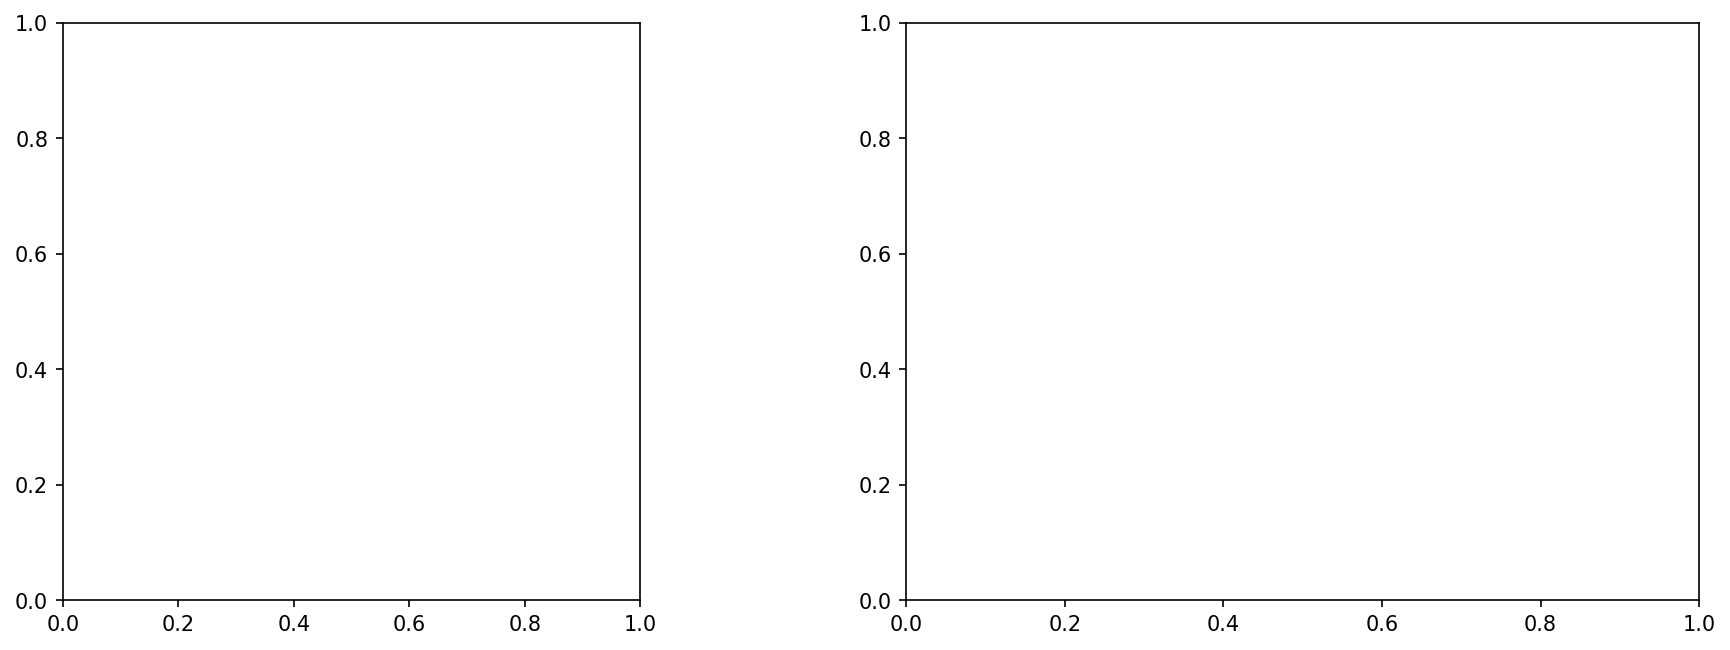

In [10]:
pinn.plotting()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data for position (x, y) and vector components (P1, P2)
x = np.array([1, 2, 3, 4, 5])
y = np.array([1, 2, 3, 4, 5])
P1 = np.array([1, -1, 2, -2, 3])
P2 = np.array([2, -2, 3, -3, 4])

# Calculate magnitude of the vectors
magnitude = np.sqrt(P1**2 + P2**2)

# Normalize vector components
P1_normalized = P1 / magnitude
P2_normalized = P2 / magnitude

# Plot the vector arrows
plt.quiver(x, y, P1_normalized, P2_normalized, magnitude, cmap='jet')
plt.colorbar(label='Magnitude')

# Set plot title and labels
plt.title('Vector Arrows')
plt.xlabel('x')
plt.ylabel('y')

# Show the plot
plt.show()
